## Load Packages and Data

In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve

from tqdm import tqdm


# this extension properly formats a cell after it is run
# !{sys.executable} -m pip install nb_black # UNCOMMENT TO INSTALL
%load_ext nb_black
%matplotlib inline

# Set the maximum number of rows to 200
pd.set_option("display.max_rows", 200)

# Set the maximum number of columns to 200
pd.set_option("display.max_columns", 200)

np.random.seed(42)

<IPython.core.display.Javascript object>

In [2]:
# Load Data
housing_raw = pd.read_csv("../data/Ames_Housing_Price_Data.csv")

housing_clean = pd.read_csv("../data/housing_cleaned.csv")  # All features included

housing_corr = pd.read_csv(
    "../data/housing_corr.csv"
)  # 13 features removed because of colinearity

<IPython.core.display.Javascript object>

In [3]:
# Raw Data
housing_raw.shape

(2580, 82)

<IPython.core.display.Javascript object>

In [4]:
# Cleaned Data
housing_clean.shape

(2559, 83)

<IPython.core.display.Javascript object>

In [5]:
# 13 features removed due to colinearity
housing_corr.shape

(2558, 65)

<IPython.core.display.Javascript object>

In [6]:
# Features Removed for Correlation Issues
set1 = set(housing_raw.columns)
set2 = set(housing_clean.columns)
set3 = set(housing_corr.columns)

print(
    "Removed ",
    len(set2.difference(set3)),
    " colinear features: \n\n",
    set2.difference(set3),
)

Removed  20  colinear features: 

 {'GarageYrBlt', 'MSSubClass', 'ExterQual', 'FullBath', 'OpenPorchSF', 'GarageArea', 'BsmtFinType1', '2ndFlrSF', 'TotalPorchSF', 'BsmtFinType2', 'YearBuilt', 'GarageCond', 'WoodDeckSF', '1stFlrSF', 'YearRemodAdd', 'TotalBsmtSF', 'EnclosedPorch', 'ScreenPorch', 'GrLivArea', 'FireplaceQu'}


<IPython.core.display.Javascript object>

#### Small Pre-Processing

In [7]:
# Removing PID column, as it is a unique identifier per row
housing_corr = housing_corr.drop("PID", axis=1)
housing_clean = housing_clean.drop("PID", axis=1)

<IPython.core.display.Javascript object>

## Label Encoding for Categorical Values

In [8]:
# In order to do regression, I need to turn categorical values into numerical values
housing_corr.dtypes

SalePrice            int64
MSZoning            object
LotFrontage        float64
LotArea              int64
Street              object
Alley               object
LotShape            object
LandContour         object
Utilities           object
LotConfig           object
LandSlope           object
Neighborhood        object
Condition1          object
Condition2          object
BldgType            object
HouseStyle          object
OverallQual          int64
OverallCond          int64
RoofStyle           object
RoofMatl            object
Exterior1st         object
Exterior2nd         object
MasVnrType          object
MasVnrArea         float64
ExterCond            int64
Foundation          object
BsmtQual             int64
BsmtCond             int64
BsmtExposure         int64
BsmtFinSF1         float64
BsmtFinSF2         float64
BsmtUnfSF          float64
Heating             object
HeatingQC            int64
CentralAir          object
Electrical          object
BsmtFullBath       float64
B

<IPython.core.display.Javascript object>

In [9]:
# List categorical columns to be label encoded for train/test
cat_cols = housing_corr.select_dtypes(include=["object"]).columns.tolist()
cat_cols2 = housing_clean.select_dtypes(include=["object"]).columns.tolist()

# Create a dictionary to store the label encoded values
cat_cols_encoded = {}

# Label Encode the categorical columns in both train/test set to values 1,2,3,4 etc.
le = LabelEncoder()
for column in cat_cols:
    housing_corr[column + "_encoded"] = le.fit_transform(housing_corr[column])
    # Store the mapping of original column to encoded column in the dictionary
    cat_cols_encoded[column] = column + "_encoded"

# Deleting all Object type columns, now that they've been replaced with labelencoded values
housing_corr_drop = housing_corr.select_dtypes(include="object").columns
housing_corr = housing_corr.drop(housing_corr_drop, axis=1)

# Create a dictionary to store the label encoded values
cat_cols_encoded2 = {}

# Label Encode the categorical columns in both train/test set to values 1,2,3,4 etc.
le2 = LabelEncoder()
for column in cat_cols2:
    housing_clean[column + "_encoded"] = le.fit_transform(housing_clean[column])
    # Store the mapping of original column to encoded column in the dictionary
    cat_cols_encoded[column] = column + "_encoded"

# Deleting all Object type columns, now that they've been replaced with labelencoded values
housing_corr_drop = housing_clean.select_dtypes(include="object").columns
housing_clean = housing_clean.drop(housing_corr_drop, axis=1)


<IPython.core.display.Javascript object>

In [10]:
# Did it work? yes!
print(housing_corr.shape, housing_corr.dtypes)
print(housing_clean.shape, housing_clean.dtypes)

(2558, 64) SalePrice                    int64
LotFrontage                float64
LotArea                      int64
OverallQual                  int64
OverallCond                  int64
MasVnrArea                 float64
ExterCond                    int64
BsmtQual                     int64
BsmtCond                     int64
BsmtExposure                 int64
BsmtFinSF1                 float64
BsmtFinSF2                 float64
BsmtUnfSF                  float64
HeatingQC                    int64
BsmtFullBath               float64
BsmtHalfBath               float64
HalfBath                     int64
BedroomAbvGr                 int64
KitchenAbvGr                 int64
KitchenQual                  int64
TotRmsAbvGrd                 int64
Fireplaces                   int64
GarageFinish                 int64
GarageCars                 float64
GarageQual                   int64
Fence                        int64
MoSold                       int64
YrSold                       int64
Age      

<IPython.core.display.Javascript object>

In [11]:
# Triple Check that there are no object values
strings = housing_corr.select_dtypes(include=["object"]).columns
print(strings)

Index([], dtype='object')


<IPython.core.display.Javascript object>

## Checking to see if any columns are just 0's

In [12]:
all_zero_cols_train = []
for col in housing_corr.columns:
    if (housing_corr[col] == 0).all():
        all_zero_cols_train.append(col)
print(all_zero_cols_train)

[]


<IPython.core.display.Javascript object>

## Train Test Split

In [13]:
# All Columns
X0 = housing_clean.loc[:, housing_clean.columns != "SalePrice"]
y0 = housing_clean.loc[:, "SalePrice"]
X0_train, X0_test, y0_train, y0_test = train_test_split(
    X0,
    y0,
    random_state=42,
    test_size=0.3,  # stratify=housing_corr["Neighborhood"] # commenting out for now
)

# Colinear Columns Removed
X = housing_corr.loc[:, housing_corr.columns != "SalePrice"]
y = housing_corr.loc[:, "SalePrice"]
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=42,
    test_size=0.3,  # stratify=housing_corr["Neighborhood"] # commenting out for now
)

<IPython.core.display.Javascript object>

In [14]:
print(X_train.shape)
print(X_test.shape)
print(X0_train.shape)
print(X0_test.shape)

(1790, 63)
(768, 63)
(1791, 81)
(768, 81)


<IPython.core.display.Javascript object>

## Model Scoring Function

In [15]:
# Creating a scoring function


def r2mae_scores(model, X, y):
    # Using R^2 as the scoring metric
    r2_scores = cross_val_score(model, X, y, cv=5, scoring="r2", n_jobs=-1)

    # Using Mean Absolute Error as the scoring metric
    mae_scores = cross_val_score(
        model, X, y, cv=5, scoring="neg_mean_absolute_error", n_jobs=-1
    )

    # Convert the MAE scores back to positive
    mae_scores = -1 * mae_scores

    avg_r2_score = np.mean(r2_scores)
    avg_MAE_score = np.mean(mae_scores)

    # Print the scores

    print("-" * 50)
    print("5-fold Cross Validation Scoring")
    print("Average R^2 score:", avg_r2_score)
    print("Average MAE score:", avg_MAE_score)
    print("-" * 50)

<IPython.core.display.Javascript object>

Note that we pass the negative of the MAE scores because scikit-learn's cross_val_score() function expects a scoring function that returns higher values for better performance, but MAE returns lower values for better performance. We then convert the negative scores back to positive by multiplying them with -1 and print the array of scores and the average score using the np.mean() function.

## Gradient Boosting Regression Model

#### All Features Model

In [16]:
# Define Model
initial_model0 = GradientBoostingRegressor()

# Fit Model
initial_model0.fit(X0_train, y0_train)

# Evaluate
r2mae_scores(initial_model0, X0_test, y0_test)

--------------------------------------------------
5-fold Cross Validation Scoring
Average R^2 score: 0.8529575223869721
Average MAE score: 16668.24334558076
--------------------------------------------------


<IPython.core.display.Javascript object>

#### Colinear Features Removed (13) Model

In [17]:
# Define Model
initial_model = GradientBoostingRegressor()

# Fit Model
initial_model.fit(X_train, y_train)

# Evaluate
r2mae_scores(initial_model, X_test, y_test)

--------------------------------------------------
5-fold Cross Validation Scoring
Average R^2 score: 0.8889389681272529
Average MAE score: 16041.948390068781
--------------------------------------------------


<IPython.core.display.Javascript object>

## Feature Selection: Optimizing # of Features

In [18]:
np.random.seed(42)

# Take inital Model and sort by feature importance
init_feat_sorted = sorted(
    zip(X_train.columns, initial_model.feature_importances_),
    key=lambda t: t[1],
    reverse=True,
)

# Loop through sorted features to get the Column names
my_cols = []
for col in init_feat_sorted:
    my_cols.append(col[0])

# Iterate through total # of features and collect scores
feature_loop_model = GradientBoostingRegressor()
my_scores = []
for i in range(0, len(my_cols)):
    feature_loop_model.fit(X_train.iloc[:, 0 : i + 1], y_train)
    score = cross_val_score(
        feature_loop_model,
        X_test.iloc[:, 0 : i + 1],
        y_test,
        cv=5,
        scoring="r2",
        n_jobs=-1,
    )
    my_scores.append((i, np.mean(score)))

<IPython.core.display.Javascript object>

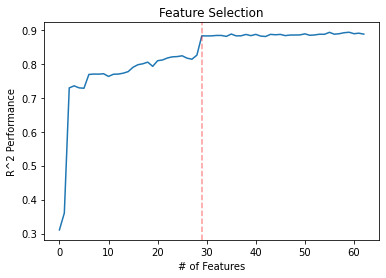

<IPython.core.display.Javascript object>

In [19]:
# Plot Scores
x_values = [t[0] for t in my_scores]
y_values = [t[1] for t in my_scores]

plt.plot(x_values, y_values)
plt.axvline(x=29, color="red", linestyle="--", alpha=0.4)

plt.xlabel("# of Features")
plt.ylabel("R^2 Performance")
plt.title("Feature Selection")

plt.show()

In [20]:
sorted_importance = sorted(
    zip(X_train.columns, initial_model.feature_importances_),
    key=lambda t: t[1],
    reverse=True,
)
sorted_importance

[('TotalSF', 0.39250356162035066),
 ('OverallQual', 0.3660695892651641),
 ('Age', 0.037698792103236914),
 ('TotalBath', 0.031109619649065747),
 ('KitchenQual', 0.031022686313285537),
 ('GarageCars', 0.016889954059281224),
 ('BsmtFinSF1', 0.016292161599914305),
 ('LotArea', 0.01418444312124612),
 ('Fireplaces', 0.013703618092204037),
 ('RemodAge', 0.011727550950256614),
 ('MasVnrArea', 0.0110331088687711),
 ('OverallCond', 0.010493732534938464),
 ('BsmtQual', 0.006341963440999774),
 ('Neighborhood_st_encoded', 0.004404492534336242),
 ('GarageType_encoded', 0.0042364162708349),
 ('TotalOutdoorSF', 0.004082945927158925),
 ('TotRmsAbvGrd', 0.003833268782609976),
 ('CentralAir_encoded', 0.0034592976094035195),
 ('HeatingQC', 0.002582998542871265),
 ('MSZoning_encoded', 0.0021090337617354774),
 ('SaleCondition_encoded', 0.0017556771753137448),
 ('BsmtExposure', 0.0016613066494576638),
 ('BsmtUnfSF', 0.0016361001719695765),
 ('Neighborhood_encoded', 0.001167480963762372),
 ('HalfBath', 0.0010

<IPython.core.display.Javascript object>

<Figure size 1440x720 with 0 Axes>

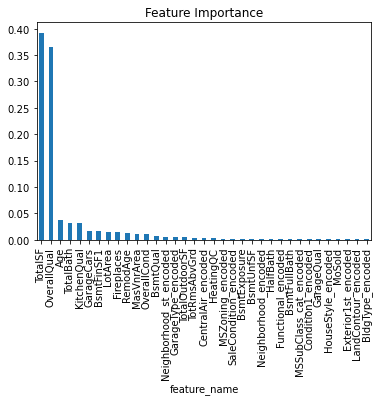

<IPython.core.display.Javascript object>

In [21]:
# Get data for the plot (35 Features based on above graph)
a, b = zip(*sorted_importance[:35])
df = pd.DataFrame({"feature_name": a, "importance_score": b})

# Plot
plt.figure(figsize=(20, 10))
df.plot.bar(x="feature_name", y="importance_score", legend=None)
plt.title("Feature Importance")
plt.show()

In [22]:
## select top 35 features
X2_train = X_train[my_cols].iloc[:, :36]  # top 35 feat importances
y2_train = y_train.copy()
X2_test = X_test[my_cols].iloc[:, :36]
y2_test = y_test.copy()

feat_select_model = GradientBoostingRegressor()
feat_select_model.fit(X2_train, y2_train)

GradientBoostingRegressor()

<IPython.core.display.Javascript object>

In [23]:
# Compare to initial model
print("feat_select_model")
r2mae_scores(feat_select_model, X2_test, y2_test)
print("\n\ninitial_model")
r2mae_scores(initial_model, X_test, y_test)

feat_select_model
--------------------------------------------------
5-fold Cross Validation Scoring
Average R^2 score: 0.8860154762624651
Average MAE score: 16274.170152137507
--------------------------------------------------


initial_model
--------------------------------------------------
5-fold Cross Validation Scoring
Average R^2 score: 0.8858678146417635
Average MAE score: 16031.884652704195
--------------------------------------------------


<IPython.core.display.Javascript object>

initial_model: 88.46%
feat_select_model: 88.30%
Feature selection actually decreased model performance by 0.1%

## Tuning the Hyper Parameters

In [24]:
## GridSearchCV - Creates Tuned Model

param_grid = {
    "n_estimators": [100, 500, 1000],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.5],
}

tuned_model_GSV = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_grid,
    cv=5,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,  # use all available CPU cores
    verbose=1,
)
tuned_model_GSV.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.5],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 500, 1000]},
             scoring='neg_mean_absolute_error', verbose=1)

<IPython.core.display.Javascript object>

In [25]:
print("Best hyperparameters: ", tuned_model_GSV.best_params_)

Best hyperparameters:  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}


<IPython.core.display.Javascript object>

In [26]:
tuned_model_GSV.cv_results_

{'mean_fit_time': array([ 0.44489698,  2.23934813,  4.42310791,  0.73521419,  3.66759148,
         7.46451173,  1.03433456,  5.31381879, 10.47707214,  0.44348011,
         2.28696241,  4.51563878,  0.75350537,  3.66626859,  7.39909439,
         1.03366828,  5.16898913, 10.33939295,  0.44352293,  2.23362546,
         4.47239976,  0.73158107,  3.70884376,  7.38875403,  1.02752123,
         4.9822772 ,  6.26055427]),
 'std_fit_time': array([0.00593414, 0.01879513, 0.0387253 , 0.01115787, 0.03261573,
        0.06665345, 0.01435884, 0.06012958, 0.0694069 , 0.0149996 ,
        0.03898106, 0.06073575, 0.0237211 , 0.01916689, 0.03529948,
        0.00946131, 0.08223202, 0.05680511, 0.00711513, 0.03001585,
        0.02919694, 0.0205802 , 0.04089253, 0.044     , 0.00777612,
        0.07281797, 1.32624637]),
 'mean_score_time': array([0.00178413, 0.00445161, 0.00590453, 0.00299087, 0.00869937,
        0.01142111, 0.00408363, 0.00889659, 0.01557989, 0.00256968,
        0.00353422, 0.00538783, 0.002

<IPython.core.display.Javascript object>

In [27]:
tuned_model = GradientBoostingRegressor(
    learning_rate=0.1, max_depth=3, n_estimators=500
)

tuned_model.fit(X_train, y_train)

GradientBoostingRegressor(n_estimators=500)

<IPython.core.display.Javascript object>

## Vizualizing Tuned Parameters

#### n_estimators vs. max_depth
Each cell of the heatmap represents the mean test score obtained by the model when it was trained. The color of each cell indicates the magnitude of the mean test score, where red represents higher mean test scores and blue represents lower mean test scores. A higher test score is better; so the combination of hyperparameters `max_depth=5` and `n_estimators=1000` is the optimize selection.

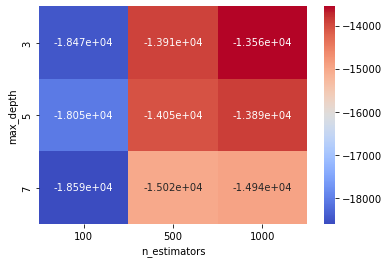

<IPython.core.display.Javascript object>

In [28]:
results = pd.DataFrame(tuned_model_GSV.cv_results_)
table = pd.pivot_table(
    results,
    values="mean_test_score",
    index="param_max_depth",
    columns="param_n_estimators",
)
sns.heatmap(
    table,
    annot=True,
    fmt=".4g",
    cmap="coolwarm",
    cbar_kws={"format": ticker.ScalarFormatter(useMathText=False)},
)
plt.xlabel("n_estimators")
plt.ylabel("max_depth")
plt.show()

#### learning_rate vs Mean Test Score
This shows that .1 is the best learning rate because it balances effeciency and effectiveness, right in the elbow. 

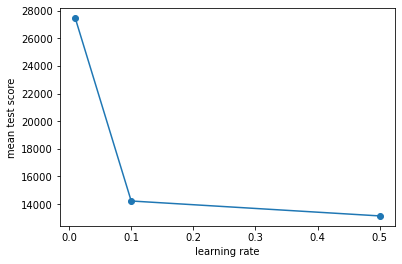

<IPython.core.display.Javascript object>

In [29]:
learning_rates = [0.01, 0.1, 0.5]
scores = [
    -tuned_model_GSV.cv_results_["mean_test_score"][i]
    for i in range(len(learning_rates))
]

plt.plot(learning_rates, scores, "-o")
plt.xlabel("learning rate")
plt.ylabel("mean test score")
plt.show()

## Evaluate the Tuned Model on TEST data

In [30]:
print("initial_model")
r2mae_scores(initial_model, X_test, y_test)

print("\n\n", "feat_select_model")
r2mae_scores(feat_select_model, X2_test, y2_test)

print("\n\ntuned_model")
r2mae_scores(tuned_model, X_test, y_test)

print("\n\ntuned_model with feat select")
r2mae_scores(tuned_model, X2_test, y2_test)

initial_model
--------------------------------------------------
5-fold Cross Validation Scoring
Average R^2 score: 0.889221144293526
Average MAE score: 15973.497303075788
--------------------------------------------------


 feat_select_model
--------------------------------------------------
5-fold Cross Validation Scoring
Average R^2 score: 0.8857001974399896
Average MAE score: 16231.121425825011
--------------------------------------------------


tuned_model
--------------------------------------------------
5-fold Cross Validation Scoring
Average R^2 score: 0.8926102357710286
Average MAE score: 15646.275516430596
--------------------------------------------------


tuned_model with feat select
--------------------------------------------------
5-fold Cross Validation Scoring
Average R^2 score: 0.8854512940160983
Average MAE score: 15925.319202082052
--------------------------------------------------


<IPython.core.display.Javascript object>

In [31]:
STOP

NameError: name 'STOP' is not defined

<IPython.core.display.Javascript object>

## YE OLD CODE DUMP

## Feature Engineering: Street Grouping
#### Function from Creating_test_train notbook with a few changes

In [ ]:
# Adding Neighborhood street back to df
streets = housing_corr[["PID", "Neighborhood_st", "SalePrice"]]

train_dummies_w_streets = pd.merge(train_dummies, streets, how="left", on="PID")
test_dummies_w_streets = pd.merge(test_dummies, streets, how="left", on="PID")

In [ ]:
## Group Streets by Sale Price ##

# creating a function to create groups based on mean sale price of streets in each
# neighborhood of the training df and adds a new column with the groups created
# It then uses the groups created using the training dataframe and creates a new column
# in the testing dataframe by mapping these groups.  This will result in missing values
# If there is a street neighborhood combination that was in the training dataset but 
# not the testing dataset


def group_neighbor_streets_by_saleprice(
    traindf=train_dummies_w_streets, testdf=test_dummies_w_streets, num_quantiles=10  # notice the difference in this line!!
):
    # Calculate the mean sale price for each street in the training df
    street_prices = traindf.groupby("Neighborhood_st")["SalePrice"].mean()
    
    # Group the streets into the specified number of quantiles based on sale price
    labels = [f"group_{i+1}" for i in range(num_quantiles)]
    groups = pd.qcut(street_prices, q=num_quantiles, labels=range(1, num_quantiles + 1))
    
    # Create a dictionary that maps each street name to its corresponding sale price group label
    street_group_dict = dict(zip(street_prices.index, groups))
    
    # Add a new column to the training dataframe with the street price groups
    traindf["StreetPriceGroup"] = traindf["Neighborhood_st"].map(street_group_dict)
    
    # Add a new column to the testing dataframe with the street price groups
    testdf["StreetPriceGroup"] = testdf["Neighborhood_st"].map(street_group_dict)
    return street_group_dict


In [ ]:
# the num of quantiles can be changed and it is assigned to d which is the dictionary that
# will be used to fill in the missing values

d = group_neighbor_streets_by_saleprice(
    traindf=train_dummies_w_streets,  # the difference here as well!!
    testdf=test_dummies_w_streets,  # the difference here as well!!
    num_quantiles=10,
)

In [ ]:
## Supporting Function to group_neighbor_streets_by_saleprice to FILL_NA's ##

# Dictionary stores missing values in the test df with another group in the same neighborhood


def fill_na(testdf=test_dummies_w_streets, d={}):  # DIFFERENT HERE TOO
    # Extract the first part of the string in the "Neighborhood_st" column
    testdf["Neighborhood_prefix"] = testdf["Neighborhood_st"].map(
        lambda x: x.split("_")[0]
    )

    # Create a new dict that only contains the neighborhood
    new_dict = {k.split("_")[0]: v for k, v in d.items()}

    # Create a list of PIDs with missing StreetPriceGroup values
    na_pid_list = testdf[testdf["StreetPriceGroup"].isna()]["PID"].tolist()

    # Create a Boolean mask to filter the DataFrame
    mask = testdf["PID"].isin(na_pid_list)

    # Apply the dictionary mapping only to the filtered rows
    testdf.loc[mask, "StreetPriceGroup"] = testdf[mask]["Neighborhood_prefix"].map(
        new_dict
    )

    # Drop the column since there is no more use for it
    testdf.drop("Neighborhood_prefix", axis=1, inplace=True)

In [ ]:
fill_na(test_dummies_w_streets, d)

In [ ]:
# Remove the column that was used to create groupings
train_dummies_w_streets.drop("Neighborhood_st", axis=1, inplace=True)
test_dummies_w_streets.drop("Neighborhood_st", axis=1, inplace=True)

In [ ]:
# Looks like PID should be removed and SalePrice moved to the first column
train_dummies_w_streets

In [ ]:
# Remove PID and move SalePrice to first column
# I need to do this in the future and save the csv's after so we dont have to do this each time

# TRAIN
train_dummies_w_streets = train_dummies_w_streets.iloc[
    :,
    train_dummies_w_streets.columns.tolist().index("SalePrice") : (
        train_dummies_w_streets.columns.tolist().index("SalePrice") + 1
    ),
].join(train_dummies_w_streets.drop(columns=["SalePrice", "PID"]))

# TEST
test_dummies_w_streets = test_dummies_w_streets.iloc[
    :,
    test_dummies_w_streets.columns.tolist().index("SalePrice") : (
        test_dummies_w_streets.columns.tolist().index("SalePrice") + 1
    ),
].join(test_dummies_w_streets.drop(columns=["SalePrice", "PID"]))

In [ ]:
# One Hot Encode it.

# List categorical columns to be dummified for train/test
cat_cols = ["StreetPriceGroup"]

# Dummify the categorical columns in both train/test set
train_dummies_w_streets2 = pd.get_dummies(train_dummies_w_streets, columns=cat_cols)
test_dummies_w_streets2 = pd.get_dummies(test_dummies_w_streets, columns=cat_cols)

# Ensure the same dummy columns are present in both train and test sets
train_dummies_w_streets2, test_dummies_w_streets2 = train_dummies_w_streets2.align(
    test_dummies_w_streets2, join="left", axis=1
)

# Fill any missing columns in the test set with zeros
test_dummies_w_streets2.fillna(0, inplace=True)

## Same processing as before

In [ ]:
# Define Model and Variables
initial_model2 = GradientBoostingRegressor()
X_train2 = train_dummies_w_streets2
y_train2 = y_train.copy()
X_test2 = test_dummies_w_streets2
y_test2 = y_test.copy()

# Drop columns with less than 20 observations in it's column
col_sums2 = X_train2.iloc[:, 45:].sum()
col_sums_filt2 = col_sums2[col_sums2 < 20]

small_dumb_cols2 = list(col_sums_filt2.index)

X_train2.drop(columns=small_dumb_cols2, inplace=True)
X_test2.drop(columns=small_dumb_cols2, inplace=True)

## Model

In [ ]:
# initial_model.set_params(verbose=1)
# initial_model.fit(X_train, y_train)
# initial_scores = cross_val_score(
#     initial_model, X_train, y_train, 
#     cv=5, 
#     scoring="neg_mean_squared_error", 
#     verbose=2
# )
# print("Initial Model RMSE: ", np.sqrt(-1 * np.mean(initial_scores)))

In [ ]:
# k-fold cross-validation

# Create the Gradient Boosted Regression model and evaluate it using k-fold cross-validation
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

mse_scores = []
r2_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = GradientBoostingRegressor(
        n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42
    )
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    mse_scores.append(mse)
    r2_scores.append(r2)

print("MSE scores:", mse_scores)
print("R-squared scores:", r2_scores)

The output shows the MSE and R-squared scores for each fold of the cross-validation. 
The MSE scores range from 322,746,634 to 949,124,370 while the R-squared scores range from 0.8501 to 0.9400. 

These scores indicate how well the model is performing on the testing data, with higher R-squared scores and lower MSE scores indicating better performance. 

The fact that the R-squared scores are relatively high and the MSE scores are relatively low suggests that the model is performing well on the data.

## Tuning

In [ ]:
def tune_gbm(learning_rate, max_depth):
    gbm = GradientBoostingRegressor(
        learning_rate=learning_rate, n_estimators=10000, max_depth=max_depth
    )
    gbm.fit(X_train, y_train)

    return gbm

def demo_gbm_tuning(model, start=0, end=10000, training_curve=True):
    """
    This function takes a GBM regression model model as input and generates a 
    performance visualization of the model using the test dataset (X_test and y_test). 
    The function calculates the mean squared error (MSE) on both the training and test 
    datasets using a generator that iteratively predicts the targets for different numbers of estimators. 
    The start and end arguments control the range of the x-axis (i.e., the number of estimators), 
    and the training_curve argument controls whether to show the training curve or not. 
    The function also prints the best test score and the corresponding number of estimators.
    """
    gen_train = model.staged_predict(X_train)
    gen_test = model.staged_predict(X_test)

    trainMSE = []
    testMSE = []
    steps = range(1, 10001)
    for n in tqdm(steps):
        y_pred_train = next(gen_train)
        y_pred_test = next(gen_test)
        trainMSE.append(mean_squared_error(y_pred_train, y_train))
        testMSE.append(mean_squared_error(y_pred_test, y_test))

    print(
        "The best test score is {:.2f} at the step {}".format(
            min(testMSE), np.argmin(testMSE) + 1
        )
    )
    print("-" * 50)
    plt.plot(range(start, end), testMSE[start:end], label="test")
    if training_curve:
        plt.plot(range(start, end), trainMSE[start:end], label="train")
    plt.legend()
    plt.show()


In [ ]:
learning_rate = 0.001
max_depth = 4

model1 = tune_gbm(learning_rate, max_depth)

start = 0
end = 10000  # change start and end to zoom in

demo_gbm_tuning(model1, start, end)

The goal is to find the optimal number of estimators where the blue line is at its lowest point while the orange line is also decreasing or leveling off. This will ensure that the model is not overfitting and is generalizing well to new data.

The curve with the lowest test MSE represents the best-performing learning rate.

You can also look at the shape of the curves to gain insight into the behavior of the model. If the curves are flat or increasing, it may indicate that the model is overfitting or underfitting the data. If the curves are decreasing and plateauing, it may suggest that the model is performing well and additional tuning may not be necessary.

In [ ]:
learning_rate = 0.05
max_depth = 4

model2 = tune_gbm(learning_rate, max_depth)

start = 0
end = 10000

demo_gbm_tuning(model2, start, end)

In [ ]:
learning_rate = 0.01
max_depth = 4

model2 = tune_gbm(learning_rate, max_depth)

start = 0
end = 10000

demo_gbm_tuning(model2, start, end)

In [ ]:
top_n = 20

sorted_importance = sorted(
    zip(X_train.columns, gbm.feature_importances_), key=lambda t: t[1], reverse=True,
)[:top_n]

sorted_importance

In [ ]:
a, b = zip(*sorted_importance)  # this splits the list of tuples into two lists
pd.DataFrame({"feature_name": a, "importance_score": b}).plot.bar(
    x="feature_name", y="importance_score", legend=None
)
plt.title("Feature Importance Plot")

In [ ]:
## Cumulative Feature Importance ##


cumulative_importance = np.cumsum([x[1] for x in sorted_importance])

plt.plot(cumulative_importance)
plt.xlabel("Number of Features")
plt.ylabel("Cumulative Feature Importance")
plt.show()

In [ ]:
## WARNING ## 
## This takes 20+min to run ##

# Grid Search for best parameters

# Define the parameter grid to search
param_grid = {
    'learning_rate': [0.1, 0.05, 0.01],
    'n_estimators': [5000, 10000, 20000]
}

# Create a GBM model
gbm = GradientBoostingRegressor(max_depth=4)

# Perform grid search with cross-validation
grid_search = GridSearchCV(gbm, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", -grid_search.best_score_)


In [ ]:
-------------------

In [ ]:
# DROPPED 2023-03-27

# None of the columns have all o's
# BUT some of the dummified columns have a very small amount of data

col_sums = X_train.iloc[:, 45:].sum()
col_sums_filt = col_sums[col_sums < 20]
print(col_sums_filt.sort_values())

# Remove all the dummified columns that were only 20 or less observations.
# out of the total 1790 observations of the train set

small_dumb_cols = list(col_sums_filt.index)

X_train.drop(columns=small_dumb_cols, inplace=True)
X_test.drop(columns=small_dumb_cols, inplace=True)

# Dropped ~78 columns
print(X_train.shape)
print(X_test.shape)